# Kinase data preprocessing

This notebook performs the following preprocessing tasks:

1. Set path to KLIFS download files
2. Load, merge and filter KLIFS metadata
3. Remove KLIFS metadata entries with missing mol2 files
4. Download PDB files for KLIFS metadata
5. Remove KLIFS metadata entries with missing PDB files 
6. Save final KLIFS dataset (metadata)
7. Analyse gap rate of KLIFS dataset

In [1]:
from pathlib import Path
import sys

from Bio.PDB import PDBList
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns

sys.path.extend(['./..'])
from kinsim_structure.auxiliary import get_mol2paths_from_metadata, split_klifs_code
from kinsim_structure.preprocessing import get_klifs_metadata_from_files, download_from_pdb
from kinsim_structure.preprocessing import get_species, get_dfg, get_unique_pdbid_per_kinase
from kinsim_structure.preprocessing import drop_missing_mol2s, drop_missing_pdbs
from kinsim_structure.preprocessing import calculate_gap_rate

sns.set()
%matplotlib inline

### 1. Set path to KLIFS download files

In [2]:
# Path to data directory
dataset_name = '20190724_full'

path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / dataset_name
path_to_results = Path('..') / 'results' / dataset_name
path_to_results.mkdir(parents=True, exist_ok=True)

#path_to_mol2 = path_to_data / 'raw' / 'KLIFS_download' / 'HUMAN' / '*' / '*' / 'pocket.mol2'
#path_to_cif = path_to_data / 'raw' / 'PDB_download' / '*.cif'

### 2. Load, merge and filter KLIFS metadata

#### Load and merge KLIFS download metadata files

In [3]:
klifs_overview_file = path_to_data / 'raw' / 'KLIFS_download' /'overview.csv'
klifs_export_file = path_to_data / 'raw'/ 'KLIFS_export.csv'

In [4]:
klifs_metadata = get_klifs_metadata_from_files(klifs_overview_file, klifs_export_file)

In [5]:
klifs_metadata.shape

(10136, 21)

#### Filter metadata by species

Keep only human entries

In [6]:
klifs_metadata.groupby('species').size()

species
Human    9661
Mouse     475
dtype: int64

In [7]:
klifs_metadata_filtered = get_species(klifs_metadata, species='Human')

In [8]:
klifs_metadata_filtered.shape

(9661, 21)

#### Filter metadata by DFG loop position

Keep only structures with DFG-in loops.

In [9]:
klifs_metadata_filtered.groupby('dfg').size()

dfg
in          8449
na           215
out          698
out-like     299
dtype: int64

In [10]:
klifs_metadata_filtered = get_dfg(klifs_metadata_filtered, dfg='in')

In [11]:
klifs_metadata_filtered.shape

(8449, 21)

#### Filter metadata by unique kinase-PDB ID combinations
Keep only the KLIFS entry per kinase-PDB ID combination with the best quality score.

In [12]:
klifs_metadata_filtered = get_unique_pdbid_per_kinase(klifs_metadata_filtered)

In [13]:
klifs_metadata_filtered.shape

(3935, 22)

### 3. Remove KLIFS metadata entries with missing mol2 files

In [14]:
klifs_metadata_filtered = drop_missing_mol2s(klifs_metadata_filtered, path_to_data)

In [15]:
klifs_metadata_filtered.shape

(3922, 22)

In [16]:
print(f'Number of unique PDB IDs in dataset: {klifs_metadata_filtered.pdb_id.unique().size}')

Number of unique PDB IDs in dataset: 3916


In [17]:
# Check if there are PDB IDs occurring multiple times for one kinase
grouped = klifs_metadata_filtered.groupby('pdb_id')['kinase'].size()
multiple_pdb_ids = list(grouped[grouped > 1].index)
klifs_metadata_filtered.loc[klifs_metadata_filtered.pdb_id.isin(multiple_pdb_ids)].sort_values('pdb_id')

,index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,ligand_orthosteric_pdb_id,...,dfg,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp
2573,1013,MAPKAPK2,MAPKAPK,CAMK,2onl,C,-,Human,-,-,...,in,in,0.798,2.852,8.0,NAIIDDYKVKVLQFALKMLKARREVELHWRASPHIVRIVDVLIVME...,4.00,0,8,NaN
3809,3825,p38a,MAPK,CMGC,2onl,B,-,Human,-,-,...,in,out-like,0.822,2.133,9.0,SPVGSGAYGSVCAVAVKKLRTYRELRLLKHMKENVIGLLDVYLVTH...,4.00,0,10,NaN
314,2363,BRAF,RAF,TKL,4mne,B,B,Human,-,-,...,in,in,0.796,1.986,6.4,QRIG____GTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,2.85,4,0,NaN
2530,2555,MAP2K1,STE7,STE,4mne,H,B,Human,PHOSPHOMETHYLPHOSPHONIC ACID ADENYLATE ESTER,ACP,...,in,out,0.833,2.218,8.0,SELGAGNGGVVFKMARKLIQIIRELQVLHECNPYIVGFYGASICME...,2.85,0,0,0000000000000010000001000000100000010000001001...
1734,1950,Erk2,MAPK,CMGC,4nif,B,B,Human,PHOSPHOAMINOPHOSPHONIC ACID-ADENYLATE ESTER,ANP,...,in,in,0.784,2.095,8.0,SYIGEGAYGMVCSVAIKKIRTLREIKILLRFRENIIGINDIYIVQD...,2.15,0,0,0000000000000010000001000000100000010000000001...
3278,4272,RSK1-b,RSKb,CAMK,4nif,D,A,Human,-,-,...,in,in,0.785,2.114,9.6,ETIGVGSYSECKRYAVKVIDPSEEIEILLRYGPNIITLKDVYLVTE...,2.15,0,4,NaN
1529,678,EGFR,EGFR,TK,4riw,D,-,Human,ADENOSINE-5'-DIPHOSPHATE,ADP,...,in,in,0.787,2.091,8.0,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,3.10,0,0,0000000000000010000000000000000000000000000000...
1691,1491,ErbB3,EGFR,TK,4riw,C,-,Human,PHOSPHOAMINOPHOSPHONIC ACID-ADENYLATE ESTER,ANP,...,in,out,0.840,2.205,8.0,KVLGSGVFGTVHKVCIKVIAVTDHMLAIGSLDAHIVRLLGLQLVTQ...,3.10,0,0,0000000000000010000001000000100000000000000001...
1530,614,EGFR,EGFR,TK,4rix,B,-,Human,ADENOSINE-5'-DIPHOSPHATE,ADP,...,in,in,0.792,2.087,8.0,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,3.10,0,0,0000000000000010000000000000000000000000000000...
1692,1473,ErbB3,EGFR,TK,4rix,A,-,Human,PHOSPHOAMINOPHOSPHONIC ACID-ADENYLATE ESTER,ANP,...,in,out,0.845,2.213,8.0,KVLGSGVFGTVHKVCIKVIAVTDHMLAIGSLDAHIVRLLGLQLVTQ...,3.10,0,0,0000000000000010000001000000000000000000000000...


### 4. Download PDB files for KLIFS metadata

In [18]:
download_from_pdb(klifs_metadata_filtered, path_to_data / 'raw' / 'PDB_download')

### 5. Remove KLIFS metadata entries with missing PDB files 

Let's check if we have PDB files for all entries in the KLIFS metadata. For PDB IDs without a corresponding cif file, remove corresponding entries in KLIFS metadata

In [19]:
# Get PDBs in KLIFS metadata
pdb_ids_metadata = klifs_metadata_filtered.pdb_id.unique()

# Get PDBs for downloaded cif files
pdb_ids_ciffiles = [i.stem for i in (path_to_data / 'raw' / 'PDB_download').glob('*')]

In [20]:
# Missing CIF files that are in the KLIFS dataset (deprecated PDB entries)
missing_cifs = set(pdb_ids_metadata) - set(pdb_ids_ciffiles)
print(f'Number of KLIFS metadata PDB IDs with missing CIF file: {len(missing_cifs)}')

Number of KLIFS metadata PDB IDs with missing CIF file: 0


In [21]:
# In case of missing cif files, try to download them again
pdbfile = PDBList()
for i in missing_cifs:
    pdbfile.retrieve_pdb_file(i, pdir=path_to_data / 'raw' / 'PDB_download')

In [22]:
# In case of missing cif files, delete corresponding PDB ID entries in KLIFS metadata
klifs_metadata_filtered = drop_missing_pdbs(klifs_metadata_filtered, path_to_data)

### 6. Save final KLIFS dataset (metadata)

In [23]:
klifs_metadata_filtered.shape

(3922, 22)

In [24]:
klifs_metadata_filtered.to_csv(path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv')

### 7. Analyse gap rate of KLIFS dataset

In [25]:
gap_rate = calculate_gap_rate(klifs_metadata_filtered)

In [26]:
def plot_gap_rate(gap_rate, klifs_metadata):
    plt.figure(figsize=(15,6))
    ax = sns.barplot(x='klifs_position', 
                     y='gap_rate', 
                     data=gap_rate,
                     color='steelblue')
    ax.set_title(f'KLIFS sequence alignment: Gap rate for the 85 residue positions ({klifs_metadata.shape[0]} KLIFS entries)',
                 fontsize=20)
    ax.set_xlabel('Alignment residue position')
    ax.set_ylabel('Gap rate')
    ax.xaxis.set_ticks(np.arange(0,85,5));
    ax.set_xticklabels(np.arange(0,85,5));
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    
    plt.savefig(path_to_results / 'plot_gap_rate.png', dpi=300)

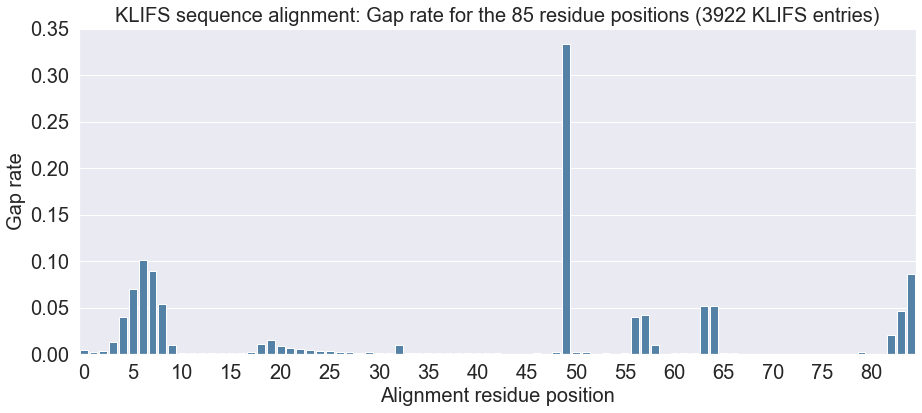

In [27]:
plot_gap_rate(gap_rate, klifs_metadata_filtered)